In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, warnings

# Import Numba for just-in-time (JIT) compilation and parallel processing


warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("/Users/shiyili/projects/kaggle/train.csv")
df = df[~df['target'].isnull()] 



print(df.shape)
print(f"Trading days: {df['date_id'].nunique()}")
print(f"Stocks: {df['stock_id'].nunique()}")

df

(5237892, 17)
Trading days: 481
Stocks: 200


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [49]:
group = df.groupby(['date_id', 'stock_id'])

# calculate wap change per stock per day
df['wap_chg_1'] = group['wap'].diff() / group['wap'].shift(1) * 100
df['imb_size_change'] = group['imb_size_with_flag'].diff()

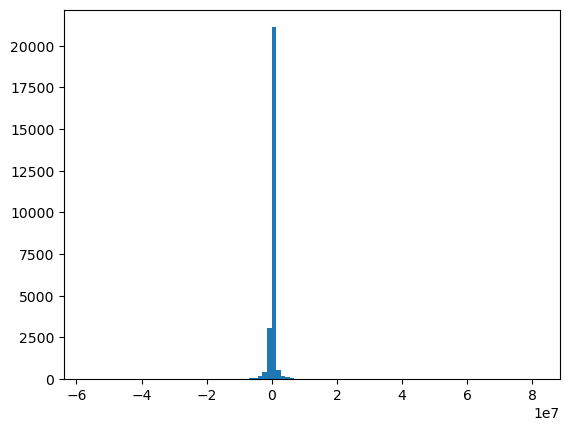

In [53]:
to_hist = df[(df.stock_id==0)]['imb_size_change']
to_hist = to_hist[(~to_hist.isnull()) & (to_hist != np.inf) & (to_hist != -np.inf)]
plt.hist(to_hist,  bins=100)
plt.show()

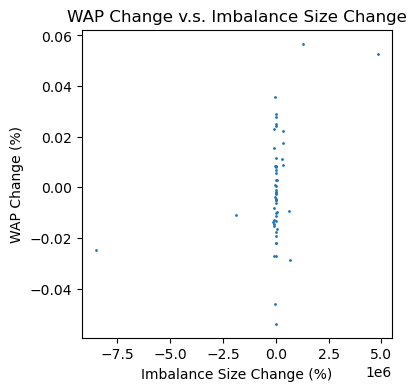

In [55]:
# plot wap change v.s. imbalance size change
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
sub_df = df[(df.stock_id==0)&(df.date_id==0)]
ax.scatter(sub_df['imb_size_change'], sub_df['wap_chg_1'], s=1)
ax.set_xlabel('Imbalance Size Change (%)')
ax.set_ylabel('WAP Change (%)')
ax.set_title('WAP Change v.s. Imbalance Size Change')
# ax.set_xlim([-100, 100])
plt.show()

In [6]:
import pandas_market_calendars as mcal

In [17]:
four_witches = [
    '20210917', '20211217',
    '20220318', '20220617', '20220916', '20221216', 
    '20230317', '20230616', '20230915', '20231215'
    ]

fomc_dates = [
    '20210827', '20211103', '20211215',
    '20220126', '20220316', '20220427', '20220615', '20220727', '20220921', '20221102', '20221214',
    '20230125', '20230315', '20230426', '20230614', '20230726', '20230920', '20231101', '20231213'
    ]

# start date is 2021-08-02 in New York time
start_date = pd.to_datetime('20210802', format='%Y%m%d')
start_date = start_date.tz_localize('America/New_York')

# count trading days using pandas_market_calendars
nyse = mcal.get_calendar('NYSE')
trading_days = nyse.schedule(start_date=start_date, end_date='20231231')
trading_days = trading_days.reset_index()
trading_days['date_id'] = trading_days['market_close'].dt.strftime('%Y%m%d')
trading_days = trading_days[['date_id', 'market_close']]

trading_days['four_witches'] = trading_days['date_id'].isin(four_witches)
trading_days['fomc'] = trading_days['date_id'].isin(fomc_dates)

trading_days['days_count'] = trading_days.index

four_witches_days = trading_days[trading_days['four_witches']]
fomc_days = trading_days[trading_days['fomc']]

In [18]:
four_witches_days

,date_id,market_close,four_witches,fomc,days_count
33,20210917,2021-09-17 20:00:00+00:00,True,False,33
97,20211217,2021-12-17 21:00:00+00:00,True,False,97
159,20220318,2022-03-18 20:00:00+00:00,True,False,159
222,20220617,2022-06-17 20:00:00+00:00,True,False,222
284,20220916,2022-09-16 20:00:00+00:00,True,False,284
348,20221216,2022-12-16 21:00:00+00:00,True,False,348
409,20230317,2023-03-17 20:00:00+00:00,True,False,409
472,20230616,2023-06-16 20:00:00+00:00,True,False,472
534,20230915,2023-09-15 20:00:00+00:00,True,False,534
598,20231215,2023-12-15 21:00:00+00:00,True,False,598


In [19]:
fomc_days

,date_id,market_close,four_witches,fomc,days_count
19,20210827,2021-08-27 20:00:00+00:00,False,True,19
66,20211103,2021-11-03 20:00:00+00:00,False,True,66
95,20211215,2021-12-15 21:00:00+00:00,False,True,95
123,20220126,2022-01-26 21:00:00+00:00,False,True,123
157,20220316,2022-03-16 20:00:00+00:00,False,True,157
186,20220427,2022-04-27 20:00:00+00:00,False,True,186
220,20220615,2022-06-15 20:00:00+00:00,False,True,220
248,20220727,2022-07-27 20:00:00+00:00,False,True,248
287,20220921,2022-09-21 20:00:00+00:00,False,True,287
317,20221102,2022-11-02 20:00:00+00:00,False,True,317
